# Temporal Convolution Neural Network with Conditioning for Broad Market Signals


<a href="" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from tqdm import tqdm

import dotenv
%load_ext dotenv

import warnings
warnings.filterwarnings("ignore")

IS_KAGGLE = os.getenv('IS_KAGGLE', 'True') == 'True'

if IS_KAGGLE:
    # Kaggle confgs
    print('Running in Kaggle...')
    %pip install yfinance
    %pip install statsmodels
    %pip install seaborn
    %pip install itertools
    %pip install scikit-learn

    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))
else:
    print('Running Local...')

import yfinance as yf
from analysis_utils import load_ticker_prices_ts_df, load_ticker_ts_df

os.getcwd()

C:\Users\adamd\AppData\Local\Temp\ipykernel_15400\3477214583.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


Running Local...


'c:\\Users\\adamd\\workspace\\quant_research'

# Financial Data

Collect market time series data (like stock prices, trading volumes, etc.).
Clean the data to handle missing values, outliers, or anomalies.
Ensure the data is in a time series format, typically with a timestamp.

In [2]:
START_DATE = "2000-01-01"
END_DATE = "2024-01-31"
DATA_DIR = "data"
INDEX = "Date"

os.makedirs(DATA_DIR, exist_ok=True)

TARGET_ETF = "SPY"  # S&P 500
RATES_INDEX = "^TNX"  # 10 Year Treasury Note Yield
VOLATILITY_INDEX = "^VIX"  # CBOE Volatility Index
MACRO_INDEX = "VEU"  # Vanguard FTSE All-World ex-US ETF
TECH_INDEX = "QQQ"
SMALLCAP_INDEX = "R2US.MI"
GOLD_INDEX = "GC=F"

tickers_symbols = [
    TARGET_ETF,
    VOLATILITY_INDEX,
    RATES_INDEX,
    MACRO_INDEX,
    TECH_INDEX,
    SMALLCAP_INDEX,
    GOLD_INDEX,
]
INTERVAL = "1d"
tickers = {}
for symbol in tickers_symbols:
    cached_file_path = f"{DATA_DIR}/{symbol}-{START_DATE}-{END_DATE}-{INTERVAL}.csv"

    try:
        if os.path.exists(cached_file_path):
            df = pd.read_csv(cached_file_path, index_col=INDEX)
            df.index = pd.to_datetime(df.index)
            assert len(df) > 0
        else:
            df = yf.download(
                symbol,
                start=START_DATE,
                end=END_DATE,
                progress=False,
                interval=INTERVAL,
            )
            assert len(df) > 0
            df.to_csv(cached_file_path)
        df.fillna(0, inplace=True)
        tickers[symbol] = df
    except Exception as e:
        print(f"Error with {symbol}: {e}")


sp500_df = tickers.get(TARGET_ETF)
vix_df = tickers.get(VOLATILITY_INDEX)
t10ytt_df = tickers.get(RATES_INDEX)
veu_df = tickers.get(MACRO_INDEX)
qqq_df = tickers.get(TECH_INDEX)
rus_df = tickers.get(SMALLCAP_INDEX)
g_df = tickers.get(GOLD_INDEX)

assert not sp500_df["Close"].isna().any().any()

g_df.tail(5)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2024-01-24,2023.199951,2033.199951,2013.900024,2013.900024,2013.900024,253
2024-01-25,2012.099976,2022.400024,2012.099976,2016.900024,2016.900024,548
2024-01-26,2021.699951,2022.400024,2016.800049,2016.800049,2016.800049,49
2024-01-29,2025.199951,2025.199951,2025.199951,2025.199951,2025.199951,150708
2024-01-30,2032.500000,2048.500000,2028.099976,2031.500000,2031.500000,26907


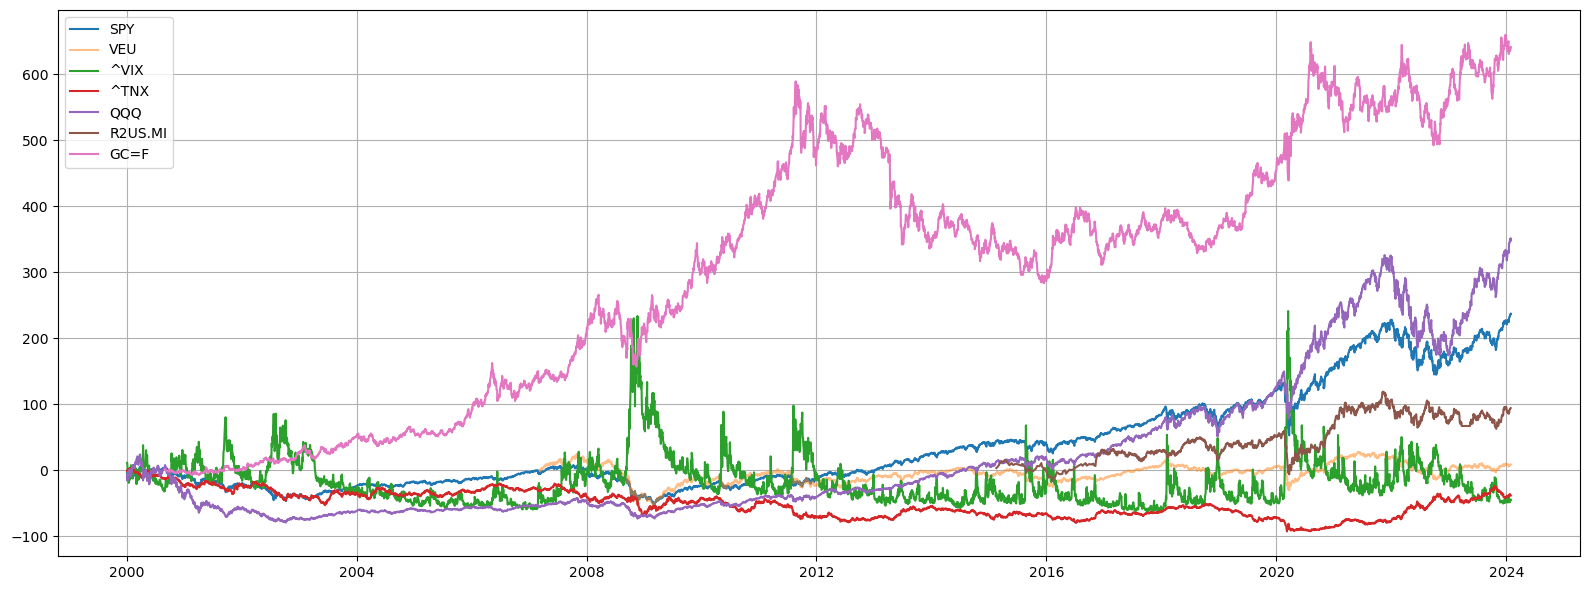

In [3]:
sp500_pr = ((1 + sp500_df["Close"].pct_change()).cumprod() - 1) * 100
veu_pr = ((1 + veu_df["Close"].pct_change()).cumprod() - 1) * 100
vix_pr = ((1 + vix_df["Close"].pct_change()).cumprod() - 1) * 100
tnx_pr = ((1 + t10ytt_df["Close"].pct_change()).cumprod() - 1) * 100
qqq_pr = ((1 + qqq_df["Close"].pct_change()).cumprod() - 1) * 100
rus_pr = ((1 + rus_df["Close"].pct_change()).cumprod() - 1) * 100
g_pr = ((1 + g_df["Close"].pct_change()).cumprod() - 1) * 100

plt.figure(figsize=(16, 6))
plt.plot(sp500_pr, label=TARGET_ETF)
plt.plot(veu_pr, label=MACRO_INDEX, alpha=0.5)
plt.plot(vix_pr, label=VOLATILITY_INDEX)
plt.plot(tnx_pr, label=RATES_INDEX)
plt.plot(qqq_pr, label=TECH_INDEX)
plt.plot(rus_pr, label=SMALLCAP_INDEX)
plt.plot(g_pr, label=GOLD_INDEX)
plt.legend(loc="upper left")
plt.grid(True)
plt.tight_layout()
plt.show()

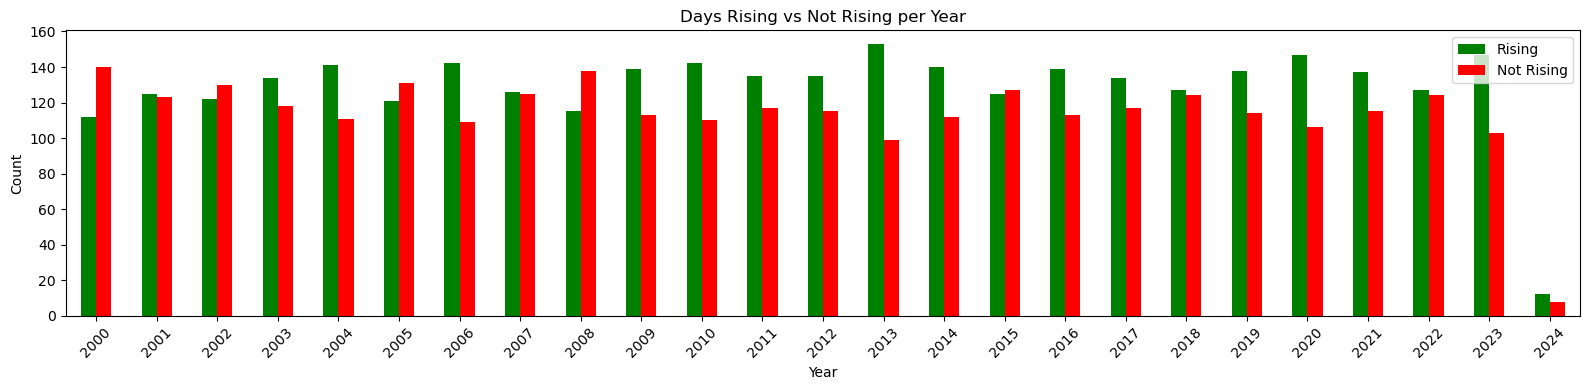

Baseline Accuracy: 53.33%


In [4]:
days_rising = sp500_df[sp500_df["Close"] > sp500_df["Open"]]
days_not_rising = sp500_df[sp500_df["Close"] <= sp500_df["Open"]]
days_rising_count = days_rising.groupby(days_rising.index.year).size()
days_not_rising_count = days_not_rising.groupby(days_not_rising.index.year).size()

total_days = sp500_df.groupby(sp500_df.index.year).size()
percentage_rising = (days_rising_count / total_days) * 100

yearly_counts = pd.DataFrame(
    {"Rising": days_rising_count, "Not Rising": days_not_rising_count}
)
yearly_counts.plot(kind="bar", color=["green", "red"], figsize=(16, 4))
plt.title("Days Rising vs Not Rising per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tick_params(axis="x", rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

print(f"Baseline Accuracy: {percentage_rising.mean():0.2f}%")

# Feature Engineering

![alt](./images/time_sincos.png)

In [5]:
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler
from tensorflow.keras.layers import Normalization
from sklego.preprocessing import RepeatingBasisFunction

MONTH_SINE = "month_sin"
MONTH_COS = "month_cos"
MONTH_RBF = "month_rbf"
DAY_SINE = "day_sin"
DAY_COS = "day_cos"
DAY_RBF = "day_rbf"
Q_SINE = "quart_sin"
Q_COS = "quart_cos"
Q_RBF = "quart_rbf"
BIZ_SINE = "biz_sin"
BIZ_COS = "biz_cos"
BIZ_RBF = "biz_rbf"
TARGET_FACTOR = 0.0003 # assume 3BP move on average
TARGET_LABEL = "Close_target"
TARGET_TS = "Close"  # The TS which we will condition.
EXOG_TS = [
    RATES_INDEX,
    MACRO_INDEX,
    VOLATILITY_INDEX,
    TECH_INDEX,
    SMALLCAP_INDEX,
    GOLD_INDEX,
]  # The TS to use for conditioning
PRICE_FEATURES = ["Open", "High", "Low", "Close"]
TIME_FEATURES = [
    DAY_RBF,
    MONTH_RBF,
    Q_RBF,
]
TS_FEATURES = ["Volume"]
TARGET_TS_FEATURES_NOTIME = EXOG_TS + TS_FEATURES + PRICE_FEATURES
TARGET_TS_FEATURES =  TARGET_TS_FEATURES_NOTIME + TIME_FEATURES
WINDOW_SIZE =  252 # int(252 / 4)  # 1 years trading, sampled across days
PREDICTION_HORIZON = 1  # next 1 trading day

print(f"target factor used: {TARGET_FACTOR}")

def create_time_features(data_df):
    """
    Encodes time cyclic features for a dataset with monthly sampling.
    Including cyclic encoding for day and year.
    :param data_df: The timeseries with a date in the format YYYY-MM-DD as index.
    :return: data_df with added wave features for month, day, and year.
    """
    if not isinstance(data_df.index, pd.DatetimeIndex):
        raise ValueError("The DataFrame index must be a DateTimeIndex.")

    def _sin_transformer(period):
        return FunctionTransformer(lambda x: np.sin(x / period * 2 * np.pi))

    def _cos_transformer(period):
        return FunctionTransformer(lambda x: np.cos(x / period * 2 * np.pi))

    def rbf_transform(x, period, input_range):
        x_normalized = (x - input_range[0]) / (input_range[1] - input_range[0]) * period
        return np.exp(-0.5 * ((x_normalized - period / 2) / 1.0) ** 2)

    data_df[DAY_RBF] = rbf_transform(data_df.index.day, 31, (1, 31))
    data_df[MONTH_RBF] = rbf_transform(data_df.index.month, 12, (1, 12))
    data_df[Q_RBF] = rbf_transform((data_df.index.month-1) // 3 + 1, 4, (1, 4))
    min_year, max_year = data_df.index.year.min(), data_df.index.year.max()
    data_df[BIZ_RBF] = rbf_transform(data_df.index.year, max_year - min_year, (min_year, max_year))

    return data_df


def create_features_df(tickers, data_df):
    """
    Create all exogenous features that lead to our target etf.
        - if the trading day close is higher than the open.
        - price log returns or 1D integrations.
    :param tickers: All the timeseries with a date in the format YYYY-MM-DD as index.
    :param data_df: Any pre-engineered features.
    :return: data_df With TARGET_LABEL timeseries at column 0, and the rest are for conditioning.
    """

    def _get_first_difference(data_df):
        return data_df # data_df.diff().fillna(0)

    def _get_log_returns(data_df):
        return np.log(data_df / data_df.shift(1)).fillna(0)

    IDX_COL = "Open"
    price_transform = FunctionTransformer(_get_first_difference)

    data_df[PRICE_FEATURES] = price_transform.fit_transform(data_df[PRICE_FEATURES])

    rates_df = tickers.get(RATES_INDEX)
    data_df[RATES_INDEX] = price_transform.fit_transform(rates_df[IDX_COL])
    macro_df = tickers.get(MACRO_INDEX)
    data_df[MACRO_INDEX] = price_transform.fit_transform(macro_df[IDX_COL])
    vix_df = tickers.get(VOLATILITY_INDEX)
    data_df[VOLATILITY_INDEX] = price_transform.fit_transform(vix_df[IDX_COL])
    tech_df = tickers.get(TECH_INDEX)
    data_df[TECH_INDEX] = price_transform.fit_transform(tech_df[IDX_COL])
    small_df = tickers.get(SMALLCAP_INDEX)
    data_df[SMALLCAP_INDEX] = price_transform.fit_transform(small_df[IDX_COL])
    g_df = tickers.get(GOLD_INDEX)
    data_df[GOLD_INDEX] = price_transform.fit_transform(g_df[IDX_COL])

    data_df = data_df.fillna(0)

    # first entry has no info due to diffs.
    return data_df.iloc[1:]

IS_CLASSIFICATION = True

def prepare_data(tickers, classify=IS_CLASSIFICATION, normalize=True):
    """
    Utility function to prepare the data.
    :data_df dataframe: dataframe with `window_size` months of data to predict the `window_size`+`horizon`.
    :param window_size: int, length of the input sequence
    :param horizon: int, forecasting horizon, defaults to 1
    :return: Array in the shape of (n_samples, n_steps, n_features)
    """
    normalizer, y_scaler = None, None
    data_df = tickers.get(TARGET_ETF).copy()
    if classify:
        data_df[TARGET_LABEL] = ((data_df["Close"] * (1 - TARGET_FACTOR)) > data_df["Open"]).astype(int)
    else:
        # A target variable with a large spread of values, in turn, may result in large error gradient values
        # causing weight values to change dramatically.
        y_scaler = MinMaxScaler(feature_range=(-1, 1))
        y_scaled = y_scaler.fit_transform(data_df[["Close"]].values * (1 - TARGET_FACTOR))
        data_df[TARGET_LABEL] = y_scaled.flatten()

    data_df = create_features_df(tickers, data_df)

    if normalize:
        normalizer = Normalization(axis=-1)
        normalizer.adapt(data_df[TARGET_TS_FEATURES_NOTIME])
        data_df_normalized = normalizer(data_df[TARGET_TS_FEATURES_NOTIME]).numpy()
    else:
        data_df_normalized = data_df[TARGET_TS_FEATURES_NOTIME]
    data_df_normalized = pd.DataFrame(data_df_normalized, columns=TARGET_TS_FEATURES_NOTIME)
    data_df_normalized = pd.concat(
        [
            data_df[TARGET_LABEL].reset_index(drop=True),
            data_df_normalized.reset_index(drop=True),
        ],
        axis=1,
    )
    if any(feature in TIME_FEATURES for feature in TARGET_TS_FEATURES):
        # We can choose later if we need time encoding. Don't normalize these.
        data_df = create_time_features(data_df)

    return data_df_normalized, normalizer, y_scaler

data_df, normalizer, y_scaler = prepare_data(tickers)
data_df.head(15)

target factor used: 0.0003


,Close_target,^TNX,VEU,^VIX,QQQ,R2US.MI,GC=F,Volume,Open,High,Low,Close
0,0,2.502730,-1.486621,0.552467,-0.228762,-0.648555,-1.931206,-1.085776,-0.512469,-0.515984,-0.539747,-0.547861
1,1,2.495899,-1.486621,0.905012,-0.272583,-0.648555,-1.931206,-1.041371,-0.546139,-0.539580,-0.562264,-0.545520
2,0,2.523982,-1.486621,0.754252,-0.278669,-0.648555,-1.931206,-1.106008,-0.549067,-0.539872,-0.557555,-0.566593
3,1,2.514115,-1.486621,0.575660,-0.317013,-0.648555,-1.931206,-1.086029,-0.542626,-0.500253,-0.535773,-0.491667
4,0,2.510320,-1.486621,0.198762,-0.238500,-0.648555,-1.931206,-1.111282,-0.486996,-0.489475,-0.488971,-0.486984
5,0,2.555860,-1.486621,0.209199,-0.231196,-0.648555,-1.931206,-1.092143,-0.491095,-0.497049,-0.503394,-0.503374
6,0,2.600640,-1.486621,0.333286,-0.257976,-0.648555,-1.931206,-1.098616,-0.502514,-0.511032,-0.509281,-0.516837
7,1,2.604435,-1.486621,0.296176,-0.262845,-0.648555,-1.931206,-1.117619,-0.503685,-0.500253,-0.505455,-0.498691
8,1,2.573317,-1.486621,-0.040134,-0.219023,-0.648555,-1.931206,-1.092864,-0.484361,-0.484231,-0.480140,-0.480252
9,1,2.636313,-1.486621,0.140778,-0.228153,-0.648555,-1.931206,-1.103170,-0.495487,-0.492096,-0.487499,-0.491081


## DIM Reduction & Feature Selection

### Dataset Balance

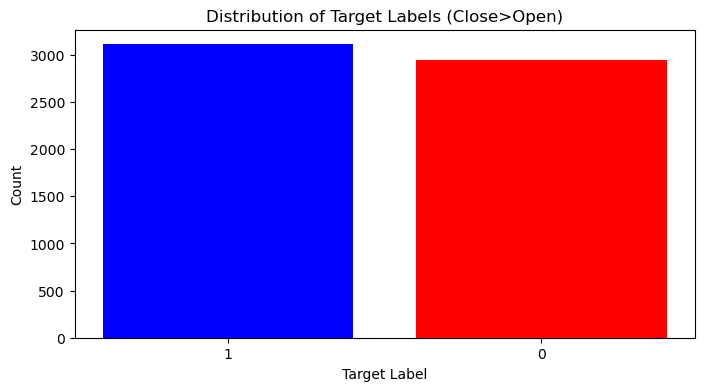

In [6]:
label_counts = data_df[TARGET_LABEL].value_counts()

plt.figure(figsize=(8, 4))
plt.bar(label_counts.index.astype(str), label_counts.values, color=['blue', 'red'])
plt.xlabel('Target Label')
plt.ylabel('Count')
plt.title('Distribution of Target Labels (Close>Open)')
plt.xticks([0, 1])
plt.show()

### PCA Analysis

We carry out a PCA to assert which features have most info to our target.

We later have a choice to use the components themselves instead of the data.

Max components for 90.0% variance: 3 out of 12


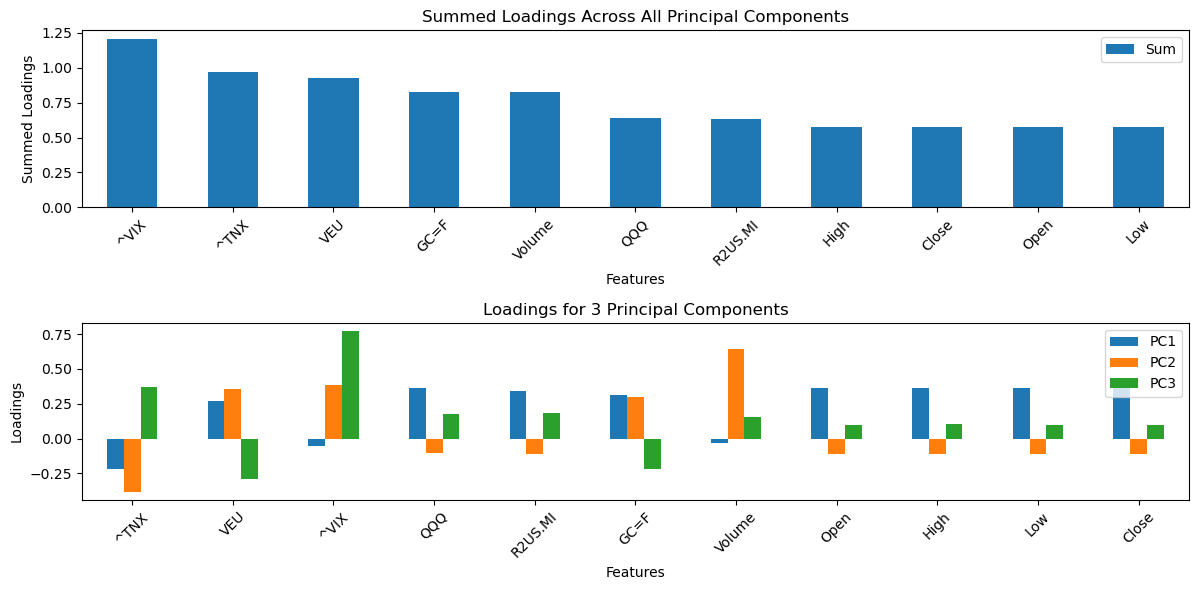

In [7]:
from sklearn.decomposition import PCA

MAX_VARIANCE = 0.90

pca = PCA()
data_df_pca = data_df.drop(columns=[TARGET_LABEL])
xdata = pca.fit_transform(data_df_pca)

cum_var_exp = np.cumsum(pca.explained_variance_ratio_)
num_components = np.argmax(cum_var_exp >= MAX_VARIANCE) + 1
print(
    f"Max components for {MAX_VARIANCE*100}% variance: {num_components} out of {data_df.shape[1]}"
)

feature_importance = pca.components_[:num_components]
loadings_df = pd.DataFrame(
    feature_importance,
    columns=data_df_pca.columns,
    index=[f"PC{i+1}" for i in range(num_components)],
).T
summed_loadings = np.sum(abs(feature_importance), axis=0)
summed_loadings_df = pd.DataFrame(
    summed_loadings, index=data_df_pca.columns, columns=["Sum"]
).sort_values(ascending=False, by="Sum")

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 6))

summed_loadings_df.plot(kind="bar", legend=False, ax=axes[0])
axes[0].set_title("Summed Loadings Across All Principal Components")
axes[0].set_ylabel("Summed Loadings")
axes[0].set_xlabel("Features")
axes[0].tick_params(axis="x", labelrotation=45)
axes[0].legend()
loadings_df.plot(kind="bar", legend=False, ax=axes[1])
axes[1].set_title(f"Loadings for {num_components} Principal Components")
axes[1].set_ylabel("Loadings")
axes[1].set_xlabel("Features")
axes[1].tick_params(axis="x", labelrotation=45)
axes[1].legend()

plt.tight_layout()
plt.show()

## Feature Evaluation

The Information Coefficient (IC), calculated here using Spearman's rank correlation. It measures the strength and direction of a monotonic relationship between two variables.

IC is useful because it can capture nonlinear relationships between variables. A high absolute value of the IC indicates a strong relationship, which could be either positive or negative.

The Mutual Information (MI) quantifies the amount of information obtained about one random variable through observing the other random variable. It's measuring how much information each feature in our dataset provides about the target variable.

Unlike correlation, MI can capture any kind of relationship between variables, not just linear or monotonic. It's particularly useful in feature selection for machine learning because it can identify features that are informative about the target variable.

Effective feature selection can improve model performance by reducing overfitting, improving accuracy, and reducing training time. It helps in simplifying models to make them more interpretable, and in focusing on the most relevant data, which can be particularly important in datasets with a large number of features.

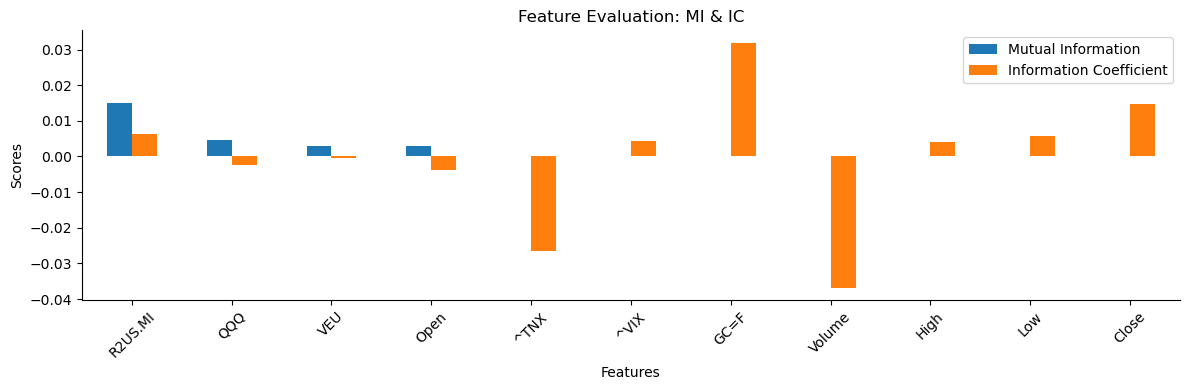

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression

ic = {}
for column in data_df.columns:
    if column != TARGET_LABEL:
        corr, p_val = spearmanr(data_df[TARGET_LABEL], data_df[column])
        ic[column] = [corr, p_val]

ic_df = pd.DataFrame(ic, index=["IC", "p-value"]).T

mi = mutual_info_regression(X=data_df.drop(columns=[TARGET_LABEL]), y=data_df[TARGET_LABEL])
mi_series = pd.Series(mi, index=data_df.drop(columns=[TARGET_LABEL]).columns)
metrics = pd.concat(
    [
        mi_series.to_frame("Mutual Information"),
        ic_df["IC"].to_frame("Information Coefficient"),
    ],
    axis=1,
)

ax = metrics.sort_values(by="Mutual Information", ascending=False).plot.bar(figsize=(12, 4), rot=45)
ax.set_xlabel("Features")
ax.set_ylabel("Scores")
ax.set_title("Feature Evaluation: MI & IC")
sns.despine()
plt.tight_layout()
plt.show()

## Feature Selection

Let's do a union of the important features from both PCA and IC/MI methods.

In [9]:
MAX_FEATURES_COUNT = 7

features_pca = summed_loadings_df.head(MAX_FEATURES_COUNT).index.tolist()
features_miic = (
    metrics.sort_values(by="Mutual Information", ascending=False)
    .head(MAX_FEATURES_COUNT)
    .index.tolist()
)
SELECTED_FEATURES = list(set(features_pca) & set(features_miic))

print(f"Selected {len(SELECTED_FEATURES)} features: {SELECTED_FEATURES}")

Selected 6 features: ['GC=F', '^VIX', '^TNX', 'VEU', 'R2US.MI', 'QQQ']


In [10]:
SELECTED_FEATURES = data_df.drop(columns=EXOG_TS).columns.to_list()
SELECTED_EXOG = EXOG_TS

SELECTED_EXOG, SELECTED_FEATURES

(['^TNX', 'VEU', '^VIX', 'QQQ', 'R2US.MI', 'GC=F'],
 ['Close_target', 'Volume', 'Open', 'High', 'Low', 'Close'])

### Multicolinearity and Variance Inflation Factor (VIF)

For feature not to be colinear, they have to score between 1 to 5.

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

data_with_constant = add_constant(data_df[SELECTED_FEATURES + SELECTED_EXOG])
vif_data = pd.DataFrame()
vif_data["feature"] = data_with_constant.columns
vif_data["VIF"] = [
    variance_inflation_factor(data_with_constant.values, i)
    for i in range(data_with_constant.shape[1])
]

print(vif_data)

         feature           VIF
0          const      2.773592
1   Close_target      1.677645
2         Volume      2.978050
3           Open  18926.083629
4           High  19118.295790
5            Low  16297.993031
6          Close  14769.639061
7           ^TNX      2.890744
8            VEU      5.533664
9           ^VIX      2.945393
10           QQQ     74.956609
11       R2US.MI      7.415832
12          GC=F      7.796277


## Time Windows Encoding

In [12]:
def prepare_windows(
    data_df,
    target_df,
    prime_ts = SELECTED_FEATURES,
    exog_ts = SELECTED_EXOG,
    window_size=WINDOW_SIZE,
    horizon=PREDICTION_HORIZON,
):
    """
    Create input and target windows suitable for TCN model.
    :param data: DataFrame with shape (n_samples, n_features)
    :param features: List of strings, names of the feature columns
    :param target: String, name of the target column
    :param window_size: int, length of the input sequence.
    :param horizon: int, forecasting horizon.
    :return: Array in the shape of (n_samples, n_steps, n_features)
    """
    X, Xexog, y = [], [], []
    for i in tqdm(
        range(len(data_df) - window_size - horizon + 1), desc="Encoding Widows"
    ):
        input_window = data_df[prime_ts].iloc[i : i + window_size].values
        X.append(input_window)

        input_window = data_df[exog_ts].iloc[i : i + window_size].values
        Xexog.append(input_window)
        if horizon == 1:
            target_value = target_df.iloc[i + window_size]
        else:
            target_value = (
                target_df.iloc[i + window_size : i + window_size + horizon].values
            )
        y.append(target_value)
    return np.array(X), np.array(Xexog), np.array(y)


X, Xexog, y = prepare_windows(data_df, data_df[TARGET_LABEL])

print(f"Label shape encoded: {y.shape}")
print(f"Data shapes for prime TS: {X.shape}, exog TS: {Xexog.shape}")
print(f"First window: {X[0,  :]}")
print(f"First window targets: {y[-WINDOW_SIZE:]}")

Encoding Widows: 100%|██████████| 5804/5804 [00:05<00:00, 1079.24it/s]


Label shape encoded: (5804,)
Data shapes for prime TS: (5804, 252, 6), exog TS: (5804, 252, 6)
First window: [[ 0.         -1.08577633 -0.5124687  -0.515984   -0.53974652 -0.5478614 ]
 [ 1.         -1.04137051 -0.54613906 -0.53958035 -0.56226438 -0.54551995]
 [ 0.         -1.10600829 -0.54906696 -0.53987169 -0.55755478 -0.56659299]
 ...
 [ 1.         -1.08285546 -0.61289436 -0.61095208 -0.60612279 -0.60434878]
 [ 0.         -1.07833791 -0.60118288 -0.60716504 -0.61936861 -0.62805587]
 [ 0.         -1.07874084 -0.62050676 -0.62697428 -0.65351337 -0.65029961]]
First window targets: [0 1 1 1 1 0 1 0 0 1 1 1 1 0 1 0 0 0 1 0 0 0 1 1 0 0 1 0 0 1 1 1 1 0 1 1 0
 0 1 0 0 1 0 1 1 0 0 1 1 0 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 1 0 0 0 1 0 1
 0 1 1 0 1 0 0 0 1 0 0 1 1 0 1 0 1 0 1 1 1 1 0 0 0 1 1 0 1 1 1 1 1 1 1 0 1
 1 0 1 0 1 1 1 0 0 1 1 1 0 1 1 1 0 1 0 1 1 0 0 1 1 0 0 0 1 1 0 1 0 1 1 1 1
 0 0 0 0 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1
 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 1 0 1 1

# TCN Architecture

In [13]:
from tensorflow.keras.layers import (
    SpatialDropout1D,
    Dropout,
    Dense,
    Conv1D,
    Layer,
    Add,
    Input,
    Concatenate,
    Flatten,
    LeakyReLU,
    Lambda,
)
from tensorflow.keras import Model

NONLINEAR_ACTIVATION = "tanh"  # LeakyReLU(alpha=0.01)


class TCNBlock(Layer):
    """
    TCN Residual Block that uses zero-padding to maintain `steps` value of the ouput equal to the one in the input.
    Residual Block is obtained by stacking togeather (2x) the following:
        - 1D Dilated Convolution
        - ReLu
        - Spatial Dropout
    And adding the input after trasnforming it with a 1x1 Conv
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    """

    def __init__(
        self,
        filters=1,
        kernel_size=2,
        dilation_rate=None,
        kernel_initializer="glorot_normal",
        bias_initializer="glorot_normal",
        kernel_regularizer=None,
        bias_regularizer=None,
        use_bias=False,
        dropout_rate=0.0,
        id=None,
        **kwargs,
    ):
        """ "
        Arguments
            filters: Integer, the dimensionality of the output space
                (i.e. the number of output filters in the convolution).
            kernel_size: An integer or tuple/list of a single integer,
                specifying the length of the 1D convolution window.
            dilation_rate: an integer or tuple/list of a single integer, specifying
                the dilation rate to use for dilated convolution.
                Usually dilation rate increases exponentially with the depth of the network.
            activation: Activation function to use
                If you don't specify anything, no activation is applied
                (ie. "linear" activation: `a(x) = x`).
            use_bias: Boolean, whether the layer uses a bias vector.
            kernel_initializer: Initializer for the `kernel` weights matrix
            bias_initializer: Initializer for the bias vector
            kernel_regularizer: Regularizer function applied to the `kernel` weights matrix
            bias_regularizer: Regularizer function applied to the bias vector
                (see [regularizer](../regularizers.md)).
        # Input shape
            3D tensor with shape: `(batch, steps, n_features)`
        # Output shape
            3D tensor with shape: `(batch, steps, filters)`
        """
        super(TCNBlock, self).__init__(**kwargs)

        assert dilation_rate > 0 and filters > 0 and kernel_size > 0

        self.filters = filters
        self.kernel_size = kernel_size
        self.dilation_rate = dilation_rate

        # Capture feature set from the input
        self.conv1 = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=use_bias,
            bias_initializer=bias_initializer,
            bias_regularizer=bias_regularizer,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=NONLINEAR_ACTIVATION,
            name=f"Conv1D_1_{id}",
        )

        # Spatial dropout is specific to convolutions by dropping an entire timewindow,
        # not to rely too heavily on specific features detected by the kernels.
        self.dropout1 = SpatialDropout1D(
            dropout_rate, trainable=True, name=f"SpatialDropout1D_1_{id}"
        )
        # Capture a higher order feature set from the previous convolution
        self.conv2 = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=use_bias,
            bias_initializer=bias_initializer,
            bias_regularizer=bias_regularizer,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=NONLINEAR_ACTIVATION,
            name=f"Conv1D_2_{id}",
        )
        self.dropout2 = SpatialDropout1D(
            dropout_rate, trainable=True, name=f"SpatialDropout1D_2_{id}"
        )

        # The skip connection is an addition of the input to the block with the output of the second dropout layer.
        # Solves vanishing gradient, carries info from earlier layers to later layers, allowing gradients to flow across this alternative path.
        # Does not learn direct mappings, but differences (residuals) while keeping temporal context.
        # Note how it keeps dims intact with kernel 1.
        self.skip_out = Conv1D(
            filters=filters,
            kernel_size=1,
            activation="linear",
            name=f"Conv1D_skipconnection_{id}",
        )
        # This is the elementwise add for the residual connection and Conv1d 2's output
        self.residual_out = Add(name=f"residual_Add_{id}")

    def apply_block(self, inputs):
        x = self.conv1(inputs)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.dropout2(x)

        # Residual output by adding the inputs back:
        skip_out_x = self.skip_out(inputs)
        x = self.residual_out([x, skip_out_x])
        return x


class ConditionalBlock(Layer):
    """
    TCN condtioning Block that conditions a target timeseries to exogenous timeserieses.
    The Block is obtained by stacking togeather the following:
        - 1D Dilated Convolution for the main TS.
        - 1D Dilated Convolution for the exog TSs.
        - 1D Dilated skip layer for both to retain history.
        - ReLu
        - Spatial Dropout
    And adding the input after trasnforming it with a 1x1 Conv
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    """

    def __init__(
        self,
        filters=1,
        kernel_size=2,
        kernel_initializer="glorot_normal",
        bias_initializer="glorot_normal",
        kernel_regularizer=None,
        bias_regularizer=None,
        use_bias=False,
        dropout_rate=0.01,
        **kwargs,
    ):
        super(ConditionalBlock, self).__init__(**kwargs)

        assert filters > 0 and kernel_size > 0

        self.filters = filters
        self.kernel_size = kernel_size
        self.kernel_initializer = kernel_initializer
        self.bias_initializer = bias_initializer
        self.kernel_regularizer = kernel_regularizer
        self.bias_regularizer = bias_regularizer
        self.use_bias = use_bias
        self.dropout_rate = dropout_rate

        self.main_conv = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=use_bias,
            bias_initializer=bias_initializer,
            bias_regularizer=bias_regularizer,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
            padding="causal",
            activation=NONLINEAR_ACTIVATION,
            name=f"Conv1D_Conditional_1",
        )
        self.main_skip_conn = Conv1D(
            filters=filters,
            kernel_size=1,
            activation="linear",
            name=f"Skip_Conditional_1",
        )
        self.cond_conv = Conv1D(
            filters=filters,
            kernel_size=kernel_size,
            use_bias=use_bias,
            bias_initializer=bias_initializer,
            bias_regularizer=bias_regularizer,
            kernel_initializer=kernel_initializer,
            kernel_regularizer=kernel_regularizer,
            padding="causal",
            activation=NONLINEAR_ACTIVATION,
            name=f"Conv1D_Conditional_2",
        )
        self.cond_skip_conn = Conv1D(
            filters=filters,
            kernel_size=1,
            activation="linear",
            name=f"Skip_Conditional_2",
        )

    def apply_block(self, inputs):
        """
        Will apply causal convolutions to every TS and concatenate the results.
        :param inputs: Array
            A list where inputs[0] is the main input and inputs[1] are the conditional inputs
        :return: Array
            Tensor of concatenated results.
        """
        main_input, cond_input = inputs[0], inputs[1] if len(inputs) > 1 else None

        x = self.main_conv(main_input)
        skip_out_x = self.main_skip_conn(main_input)
        x = Add()([x, skip_out_x])
        if cond_input is not None:
            cond_x = self.cond_conv(cond_input)
            cond_skip_out_x = self.cond_skip_conn(cond_input)
            cond_x = Add()([cond_x, cond_skip_out_x])
            x = Concatenate(axis=-1)([x, cond_x])
        return x


def TCN(
    input_shape,
    dense_units=None,
    conditioning_shapes=None,
    output_horizon=1,
    num_filters=32,
    num_layers=1,
    kernel_size=2,
    dilation_rate=2,
    kernel_initializer="glorot_normal",
    bias_initializer="glorot_normal",
    kernel_regularizer=None,
    bias_regularizer=None,
    use_bias=False,
    dropout_rate=0.01,
):
    """
    Tensorflow TCN Model builder.
    forked and extended from: https://github.com/albertogaspar/dts/blob/master/dts/models/TCN.py
    see: https://www.tensorflow.org/api_docs/python/tf/keras/Model
    see: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing#the_model_class
    see: https://www.tensorflow.org/api_docs/python/tf/keras/regularizers/L2

    :param layers: int
        Number of layers for the network. Defaults to 1 layer.
    :param filters: int
        the number of output filters in the convolution. Defaults to 32.
    :param kernel_size: int or tuple
        the length of the 1D convolution window
    :param dilation_rate: int
        the dilation rate to use for dilated convolution. Defaults to 1.
    :param output_horizon: int
        the output horizon.
    """

    MAX_FILTER = 512

    main_input = Input(shape=input_shape, name="main_input")
    cond_input = (
        Input(shape=conditioning_shapes, name="exog_input")
        if conditioning_shapes is not None and len(conditioning_shapes) > 0
        else None
    )

    x = main_input
    if cond_input is not None:
        x = ConditionalBlock(
            filters=num_filters,
            kernel_size=kernel_size,
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            use_bias=use_bias,
            dropout_rate=dropout_rate,
        ).apply_block([x] + [cond_input])
    for i in range(num_layers):
        x = TCNBlock(
            filters=np.min([num_filters * (i + 1), MAX_FILTER]),
            kernel_size=kernel_size,
            dilation_rate=dilation_rate ** (i + 1),
            kernel_initializer=kernel_initializer,
            bias_initializer=bias_initializer,
            kernel_regularizer=kernel_regularizer,
            bias_regularizer=bias_regularizer,
            use_bias=use_bias,
            dropout_rate=dropout_rate,
            id=i,
        ).apply_block(x)
    if dense_units is not None and len(dense_units) > 0:
        x = Flatten()(x)
        for idx, units in enumerate(dense_units):
            x = Dense(
                units,
                activation="relu",
                name=f"Hidden_Dense_{idx}",
                kernel_regularizer=kernel_regularizer,
            )(x)
    else:
        x = Lambda(lambda x: x[:, -output_horizon:, 0])(x)
    outputs = Dense(output_horizon, activation="sigmoid", name=f"Output_Classifier")(x)
    model = Model(
        inputs=[main_input, cond_input] if cond_input is not None else [main_input],
        outputs=outputs,
        name="TCN_Conditional_Model",
    )

    return model

# Train Model
Using tensorbards: `tensorboard --logdir logs/hparam_tuning`

In [14]:
import os
import shutil

DELETE_OLD_LOGS = True

LOG_BASEPATH = "./logs"
if DELETE_OLD_LOGS and os.path.exists(LOG_BASEPATH):
    assert os.path.isdir(LOG_BASEPATH)
    shutil.rmtree(LOG_BASEPATH)

## Hyper Parameters

In [15]:
from tensorboard.plugins.hparams import api as hp
from datetime import datetime
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
import json
import pickle

VAL_SPLIT = 0.15
EPOCHS = 150
PATIENCE_EPOCHS = 10
BATCH_SIZE = 128
FILTER = 1
HIDDEN_DENSE=None # [32, 128]
BIAS=True
DROPRATE = 0.2
POOL_SIZE = 5
KERNEL_SIZE = 2
DILATION_RATE = 1
MAX_LAYERS = 1
REG_WEIGHTS = 0.005
LEARN_RATE = 0.05
MODEL_LOG_DIR = f'{LOG_BASEPATH}/{datetime.now().strftime("%d%H%M%S")}'
CV_SPLITS = 5
TARGET_METRIC = "accuracy" if IS_CLASSIFICATION else "mae"
LOSS = "binary_crossentropy" if IS_CLASSIFICATION else TARGET_METRIC
METRICS = [TARGET_METRIC]

### Build, CV and Grid

In [16]:
from tensorflow.keras.regularizers import L2, L1L2
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard,ModelCheckpoint,ProgbarLogger,ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.summary import create_file_writer
from tensorflow.debugging.experimental import enable_dump_debug_info
enable_dump_debug_info(LOG_BASEPATH, tensor_debug_mode="FULL_HEALTH", circular_buffer_size=-1)

# See: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ParameterGrid.html
# See paper: https://www.mdpi.com/2076-3417/10/7/2322
HP_NUM_FILTERS = hp.HParam("num_filters", hp.Discrete([FILTER * 2, FILTER]))
HP_KERNEL_SIZE = hp.HParam("kernel_size", hp.Discrete([KERNEL_SIZE * 2, KERNEL_SIZE]))
HP_BATCH_SIZE = hp.HParam("batch_size", hp.Discrete([BATCH_SIZE]))
HP_EPOCHS = hp.HParam("epochs", hp.Discrete([EPOCHS]))
HP_DILATION_RATE = hp.HParam("dilation_rate", hp.Discrete([DILATION_RATE]))
HP_DROPOUT_RATE = hp.HParam("dropout_rate", hp.Discrete([DROPRATE, 0.5]))
HP_NUM_LAYERS = hp.HParam("num_layers", hp.Discrete([MAX_LAYERS * 2, MAX_LAYERS]))
HP_REG_WEIGHTS = hp.HParam("reg_weight", hp.Discrete([REG_WEIGHTS, 0.0005]))
HP_LEARNING_RATE = hp.HParam("learning_rate", hp.Discrete([LEARN_RATE]))
HP_PATIENCE = hp.HParam("patience", hp.Discrete([PATIENCE_EPOCHS]))
HP_BIAS = hp.HParam("bias", hp.Discrete([BIAS]))
HP_LOSS = hp.HParam("loss", hp.Discrete([LOSS]))
HP_HIDDEN_DENSE = hp.HParam("dense_units", hp.Discrete([
    "64_128",
    "16_32",
    "16_32_32_64",
    "32_64_128_128_64_32",
]))

HPARAMS = [
    HP_NUM_FILTERS,
    HP_KERNEL_SIZE,
    HP_BATCH_SIZE,
    HP_EPOCHS,
    HP_DILATION_RATE,
    HP_DROPOUT_RATE,
    HP_NUM_LAYERS,
    HP_REG_WEIGHTS,
    HP_LEARNING_RATE,
    HP_PATIENCE,
    HP_BIAS,
    HP_LOSS,
    HP_HIDDEN_DENSE
]


def build_tcn(
    input_shape, X, y, Xt=None, yt=None,
    conditioning_shapes=None,
    val_split=VAL_SPLIT,
    output_horizon=PREDICTION_HORIZON,
    num_filters=FILTER,
    kernel_size=KERNEL_SIZE,
    num_layers=MAX_LAYERS,
    dilation_rate=DILATION_RATE,
    kernel_regularizer=L1L2(l1=REG_WEIGHTS, l2=REG_WEIGHTS),
    bias_regularizer=L1L2(l1=REG_WEIGHTS, l2=REG_WEIGHTS),
    dropout_rate=DROPRATE,
    dense_units=HIDDEN_DENSE,
    lr=LEARN_RATE,
    patience=PATIENCE_EPOCHS,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    use_bias=BIAS,
    loss=LOSS,
):
    model = TCN(
        input_shape=input_shape,
        conditioning_shapes=conditioning_shapes,
        dense_units=dense_units,
        output_horizon=output_horizon,
        num_filters=num_filters,
        kernel_size=kernel_size,
        num_layers=num_layers,
        dilation_rate=dilation_rate,
        kernel_regularizer=kernel_regularizer,
        bias_regularizer=bias_regularizer,
        use_bias=use_bias,
        dropout_rate=dropout_rate,
    )
    model.compile(loss=loss, optimizer=Adam(lr), metrics=METRICS)
    callbacks = [
        EarlyStopping(
            patience=patience,
            monitor=f"val_{TARGET_METRIC}",
            restore_best_weights=True,
        ),
        TensorBoard(log_dir=MODEL_LOG_DIR, profile_batch=10),
        ModelCheckpoint(filepath=MODEL_LOG_DIR,
                        save_weights_only=True,
                        monitor=f"val_{TARGET_METRIC}",
                        mode='max',
                        save_best_only=True),
        ProgbarLogger(),
        ReduceLROnPlateau(
            monitor=f"val_{TARGET_METRIC}",
            factor=0.25,
            patience=PATIENCE_EPOCHS//2,
            verbose=1,
            mode='auto',
            min_delta=0.00001,
            min_lr=0,
        )
        ]
    if Xt is not None:
        history = model.fit(
            X,
            y,
            validation_data=(Xt, yt),
            epochs=epochs,
            batch_size=batch_size,
            callbacks=callbacks,
            verbose=1,
        )
    else:
        history = model.fit(
            X,
            y,
            validation_split=val_split,
            epochs=EPOCHS,
            batch_size=BATCH_SIZE,
            callbacks=callbacks,
            verbose=1,
        )
    return model, history

def grid_search_build_tcn(
    input_shape, X, y, hparams=HPARAMS, file_name="best_params.json"
):
    def decode_dense_units(config_str):
        return [int(unit) for unit in config_str.split('_')]

    def _save_best_params(best_params, best_loss, best_metric, file_name="best_params.json"):
        with open(file_name, "w") as file:
            json.dump({"best_params": best_params, "best_loss": best_loss, "best_metric": best_metric}, file)

    with create_file_writer(f"{MODEL_LOG_DIR}/hparam_tuning").as_default():
        hp.hparams_config(
            hparams=hparams,
            metrics=[hp.Metric(TARGET_METRIC, display_name=TARGET_METRIC)],
        )
    grid = list(ParameterGrid({h.name: h.domain.values for h in hparams}))
    best_model = None
    best_loss = np.inf
    best_metric = np.inf if not IS_CLASSIFICATION else -np.inf
    best_params = None
    best_history = None
    for hp_values in tqdm(grid, desc="Grid Search.."):
        try:
            dense_units = decode_dense_units(hparams[HP_HIDDEN_DENSE])
            model, history = build_tcn(input_shape, X, y,
                                        output_horizon=PREDICTION_HORIZON,
                                        num_filters=hp_values["num_filters"],
                                        kernel_size=hp_values["kernel_size"],
                                        num_layers=hp_values["num_layers"],
                                        dilation_rate=hp_values["dilation_rate"],
                                        kernel_regularizer=L1L2(l1=hp_values["reg_weight"], l2=hp_values["reg_weight"]),
                                        bias_regularizer=L1L2(l1=hp_values["reg_weight"], l2=hp_values["reg_weight"]),
                                        dropout_rate=hp_values["dropout_rate"],
                                        epochs=hp_values["epochs"],
                                        lr=hp_values["learning_rate"],
                                        dense_units=dense_units,
                                        use_bias=hp_values["bias"],)
            loss = np.min(history.history[f"val_loss"])
            metric = np.min(history.history[f"val_{TARGET_METRIC}"])
            if best_loss < loss or (best_metric < metric and not IS_CLASSIFICATION) or (best_metric > metric and IS_CLASSIFICATION):
                best_history = history
                best_loss = loss
                best_metric = metric
                best_model = model
                best_params = hp_values
                _save_best_params(best_params, best_loss, best_metric, file_name)
        except Exception as e:
            print(f"Grid Search ERROR on params: {hp_values}\n", e)

    return best_model, best_history


def train_cv_model(X, y, input_shape, n_splits=CV_SPLITS):
    results = []
    tscv = TimeSeriesSplit(n_splits=n_splits)
    for train_index, test_index in tscv.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        try:
            model = build_tcn(input_shape, X_train, y_train, X_test, y_test)
            result = model.evaluate(X_test, y_test)
            results.append(result)
        except Exception as e:
            print(f"CV error!", e)

    return results

INFO:tensorflow:Enabled dumping callback in thread MainThread (dump root: ./logs, tensor debug mode: FULL_HEALTH)


### Shape and Train

In [17]:
from tensorflow.keras.models import load_model

MODEL_DIR = f"./models/{datetime.now().strftime('%Y%m%d-%H')}"

os.makedirs(MODEL_DIR, exist_ok=True)
assert os.path.exists(MODEL_DIR)

LOAD_MODEL_CACHE = False
GRID_SEARCH_TRAIN = False

if LOAD_MODEL_CACHE:
    model = load_model(f"{MODEL_DIR}/tcn.h5")
    with open(f"{MODEL_DIR}/history.pkl", 'rb') as file:
        loaded_history = pickle.load(file)
else:
    input_shape = (
        WINDOW_SIZE,
        1 if len(X.shape) < 3 else X.shape[2],
    )  # if we have no additonal features X.shape[1]
    conditioning_shapes = (WINDOW_SIZE, Xexog.shape[2])
    print(f"Model logs for Tensorboard available here: {MODEL_LOG_DIR}")
    print(f"Input Shape: {input_shape}")

    assert not np.any(np.isnan(X))
    assert not np.any(np.isnan(Xexog))
    assert not np.any(np.isnan(y))

    if GRID_SEARCH_TRAIN:
        model, history = grid_search_build_tcn(input_shape, X, y)
    else:
        model, history = build_tcn(
            input_shape, [X, Xexog], y, conditioning_shapes=conditioning_shapes
        )
    model.save(f"{MODEL_DIR}/tcn.h5")
    with open(f"{MODEL_DIR}/history.pkl", "wb") as file:
        pickle.dump(history.history, file)

model.summary()

Model logs for Tensorboard available here: ./logs/03012417
Input Shape: (252, 6)
Epoch 1/150
39/39 [==============================] - 38s 977ms/sample - loss: 0.7846 - accuracy: 0.5005 - val_loss: 0.7006 - val_accuracy: 0.5316
Epoch 2/150
39/39 [==============================] - 7s 182ms/sample - loss: 0.6977 - accuracy: 0.5066 - val_loss: 0.7085 - val_accuracy: 0.4684
Epoch 3/150
39/39 [==============================] - 7s 186ms/sample - loss: 0.6954 - accuracy: 0.5100 - val_loss: 0.6956 - val_accuracy: 0.4902
Epoch 4/150
39/39 [==============================] - 7s 190ms/sample - loss: 0.6935 - accuracy: 0.5119 - val_loss: 0.6950 - val_accuracy: 0.4799
Epoch 5/150
39/39 [==============================] - 7s 187ms/sample - loss: 0.6935 - accuracy: 0.5068 - val_loss: 0.7017 - val_accuracy: 0.4684
Epoch 6/150
39/39 [==============================] - 7s 184ms/sample - loss: 0.6938 - accuracy: 0.5033 - val_loss: 0.6959 - val_accuracy: 0.4776

Epoch 6: ReduceLROnPlateau reducing learning ra

### Tensorboard for profiling.

In [18]:
from tensorboard import program

tb = program.TensorBoard()
tb.configure(argv=[None, '--logdir', LOG_BASEPATH, '--bind_all'])
url = tb.launch()
print(f"TensorBoard started at {url}")

TensorBoard started at http://DESKTOP-2E58CIV:6006/


# Evaluation

In [20]:
VAL_SIZE = round(len(X) * VAL_SPLIT)

train_data = X[:-VAL_SIZE]
test_data = X[-VAL_SIZE:]
train_exog_data = Xexog[:-VAL_SIZE]
test_exog_data = Xexog[-VAL_SIZE:]
ytrain_data = y[:-VAL_SIZE]
ytest_data = y[-VAL_SIZE:]
if y_scaler is not None:
    ytrain_data = y_scaler.inverse_transform(ytrain_data.reshape(-1, 1))
    ytest_data = y_scaler.inverse_transform(ytest_data.reshape(-1, 1))


print(f"Test data shape: {ytest_data.shape}")
print(f"Test data 1 horizon sample: {ytest_data[0]}")

y_pred = model.predict([train_data, train_exog_data])
print(f"y_pred shape: {y_pred.shape}")
yt_pred = model.predict([test_data, test_exog_data])
if IS_CLASSIFICATION:
    y_pred_orig = y_pred.copy()
    yt_pred_orig = yt_pred.copy()
    y_pred = (y_pred > 0.5).astype(int)
    yt_pred = (yt_pred > 0.5).astype(int)
else:
    y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
    yt_pred = y_scaler.inverse_transform(yt_pred.reshape(-1, 1))
print(f"Prediction shape: {yt_pred.shape}")
print(f"Prediction 1 horizon sample: {yt_pred[0].flatten()} VS {ytest_data[0]}")

Test data shape: (871,)
Test data 1 horizon sample: 1


155/155 [==============================] - 10s 50ms/step
y_pred shape: (4933, 1)
28/28 [==============================] - 1s 48ms/step
Prediction shape: (871, 1)
Prediction 1 horizon sample: [1] VS 1


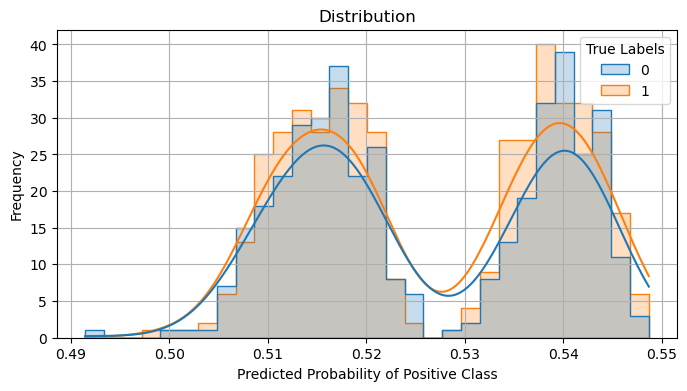

In [21]:
pred_df = pd.DataFrame({'True Labels': ytest_data, 'Predicted Probabilities': yt_pred_orig.flatten()})

plt.figure(figsize=(8, 4))
sns.histplot(data=pred_df, x='Predicted Probabilities', hue='True Labels', bins=30, kde=True, element='step')
plt.title('Distribution')
plt.xlabel('Predicted Probability of Positive Class')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

### Confusion Matrices

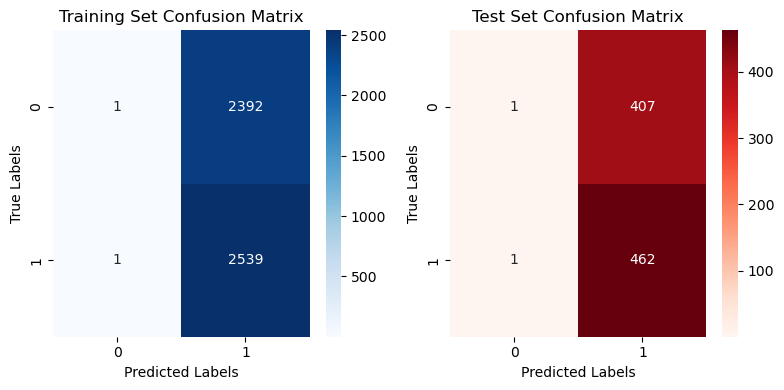

In [22]:
from tensorflow.math import confusion_matrix

cm_train = confusion_matrix(ytrain_data, y_pred)
cm_test = confusion_matrix(ytest_data, yt_pred)

cm_train_np = cm_train.numpy()
cm_test_np = cm_test.numpy()

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
sns.heatmap(cm_train_np, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Training Set Confusion Matrix')
plt.subplot(1, 2, 2)
sns.heatmap(cm_test_np, annot=True, fmt='d', cmap='Reds', xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Test Set Confusion Matrix')

plt.tight_layout()
plt.show()


shapes y_pred: (4933, 1) and yt_pred: (871, 1)


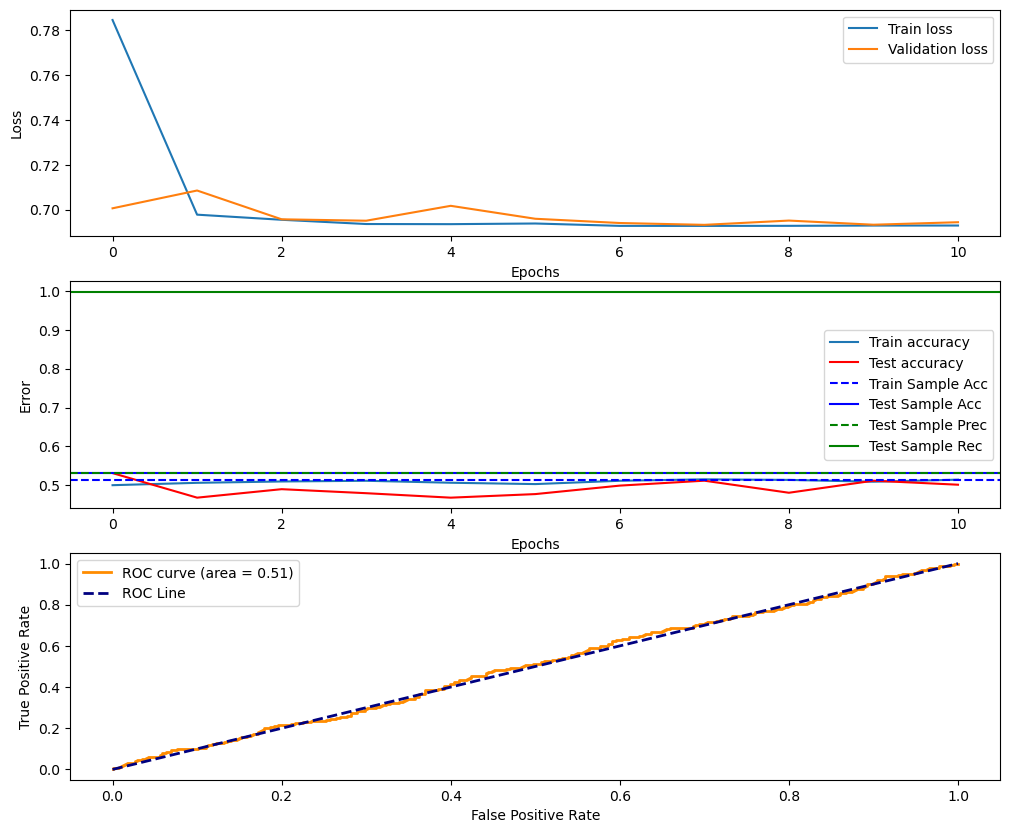

,Accuracy,Precision,Recall,F1 Score,ROC AUC
Test,0.531573,0.531646,0.99784,0.693694,0.50622


In [23]:
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_percentage_error,
    mean_absolute_error,
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
)

def directional_accuracy(y, y_pred):
    a = np.array(y).flatten()
    p = np.array(y_pred).flatten()

    a_dir = np.sign(np.diff(a))
    p_dir = np.sign(np.diff(p))
    correct_dirs = np.sum(a_dir == p_dir)
    acc = correct_dirs / len(a_dir)

    return acc


print(f"shapes y_pred: {y_pred.shape} and yt_pred: {yt_pred.shape}")

if not IS_CLASSIFICATION:
    mae_train = mean_absolute_error(ytrain_data, y_pred)
    mae_test = mean_absolute_error(ytest_data, yt_pred)
    mse_train = mean_squared_error(ytrain_data, y_pred)
    mse_test = mean_squared_error(ytest_data, yt_pred)
    rmse_train = mean_squared_error(ytrain_data, y_pred, squared=False)
    rmse_test = mean_squared_error(ytest_data, yt_pred, squared=False)
    mape_train = mean_absolute_percentage_error(ytrain_data, y_pred) * 100
    mape_test = mean_absolute_percentage_error(ytest_data, yt_pred) * 100
    r2 = r2_score(
        ytest_data,
        yt_pred,
    )
    da_test = directional_accuracy(ytest_data, yt_pred)
    metrics_df = pd.DataFrame(
        {
            "MAE": [mae_test],
            "MSE": [mse_test],
            "RMSE": [rmse_test],
            "MAPE": [mape_test],
            "R2": [r2],
            "DA": [da_test],
        }
    )
else:
    accuracy_train = accuracy_score(ytrain_data, y_pred)
    accuracy_test = accuracy_score(ytest_data, yt_pred)
    precision_test = precision_score(ytest_data, yt_pred)
    recall_test = recall_score(ytest_data, yt_pred)
    f1_test = f1_score(ytest_data, yt_pred)
    roc_auc_test = roc_auc_score(ytest_data, yt_pred_orig)
    metrics_df = pd.DataFrame({
        "Accuracy": [accuracy_test],
        "Precision": [precision_test],
        "Recall": [recall_test],
        "F1 Score": [f1_test],
        "ROC AUC": [roc_auc_test],
    }, index=["Test"])

fig, axs = plt.subplots(3 if IS_CLASSIFICATION else 2, 1, figsize=(12, 10))
axs[0].plot(history.history["loss"], label="Train loss")
axs[0].plot(history.history["val_loss"], label="Validation loss")
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[0].legend()
axs[1].plot(
    history.history[TARGET_METRIC],
    label=f"Train {TARGET_METRIC}",
)
axs[1].plot(
    history.history[f"val_{TARGET_METRIC}"],
    label=f"Test {TARGET_METRIC}",
    color="r",
)
if not IS_CLASSIFICATION:
    axs[1].axhline(mae_test, color="b", linestyle="--", label="Train Sample MAE")
    axs[1].axhline(mae_train, color="b", linestyle="-", label="Test Sample MAE")
    axs[1].axhline(rmse_train, color="r", linestyle="--", label="Train Sample RMSE")
    axs[1].axhline(rmse_test, color="r", linestyle="-", label="Test Sample RMSE")
else:
    axs[1].axhline(accuracy_train, color="b", linestyle="--", label="Train Sample Acc")
    axs[1].axhline(accuracy_test, color="b", linestyle="-", label="Test Sample Acc")
    axs[1].axhline(precision_test, color="g", linestyle="--", label="Test Sample Prec")
    axs[1].axhline(recall_test, color="g", linestyle="-", label="Test Sample Rec")
axs[1].set_xlabel("Epochs")
axs[1].set_ylabel("Error")
axs[1].legend()

if IS_CLASSIFICATION:
    fpr, tpr, _ = roc_curve(ytest_data, yt_pred_orig)
    roc_auc_test = auc(fpr, tpr)
    axs[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc_test)
    axs[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='ROC Line')
    axs[2].set_xlabel('False Positive Rate')
    axs[2].set_ylabel('True Positive Rate')
    axs[2].legend()

plt.show()

metrics_df

# Conclusion




![]()

## References

- [YFinance Github](https://github.com/ranaroussi/yfinance)
- [Vanguard All World excluding US](https://investor.vanguard.com/investment-products/etfs/profile/veu)


## Github

Article here is also available on [Github]()

Kaggle notebook available [here]()


## Media

All media used (in the form of code or images) are either solely owned by me, acquired through licensing, or part of the Public Domain and granted use through Creative Commons License.

## CC Licensing and Use

<a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-nc/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-nc/4.0/">Creative Commons Attribution-NonCommercial 4.0 International License</a>.